In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df=pd.read_json('sarcasm_detection_shared_task_twitter_training.jsonl',lines=True)

In [3]:
df.head()

,label,response,context
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     5000 non-null   object
 1   response  5000 non-null   object
 2   context   5000 non-null   object
dtypes: object(3)
memory usage: 117.3+ KB


In [5]:
df['label'].value_counts()

NOT_SARCASM    2500
SARCASM        2500
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

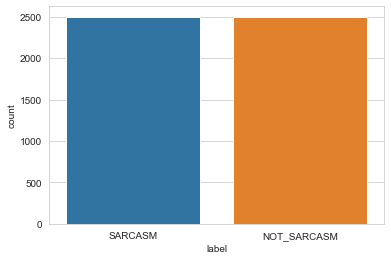

In [6]:
sns.set_style('whitegrid')
sns.countplot(x='label',data=df)

In [7]:
df['response']=df['response'].str.replace('@USER', "") 
df['response']=df['response'].str.replace('\d+', '')
df['response']=df['response'].str.lower()
df['response']=df['response'].str.replace('[^\w\s]','')

df['context']=df['context'].apply(lambda x: ','.join(map(str, x)))
df['context']=df['context'].str.replace('@USER', "") 
df['context']=df['context'].str.lower()
df['context']=df['context'].str.replace('[^\w\s]','')
df['context']=df['context'].str.replace('\d+', '')

df.head()

<ipython-input-7-c9cae9c58653>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['response']=df['response'].str.replace('\d+', '')
<ipython-input-7-c9cae9c58653>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['response']=df['response'].str.replace('[^\w\s]','')
<ipython-input-7-c9cae9c58653>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['context']=df['context'].str.replace('[^\w\s]','')
<ipython-input-7-c9cae9c58653>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['context']=df['context'].str.replace('\d+', '')


,label,response,context
0,SARCASM,i dont get this obviously you do care or y...,a minor child deserves privacy and should be k...
1,SARCASM,trying to protest about talking about him a...,why is he a loser hes just a press secretar...
2,SARCASM,he makes an insane about of money from the ...,donald j trump is guilty as charged the evid...
3,SARCASM,meanwhile trump wont even release his sat sc...,jamie raskin tanked doug collins collins look...
4,SARCASM,pretty sure the antilincoln crowd claimed th...,man y all gone both sides the apocalypse o...


In [8]:
X=df['context'].values
y=df['label'].values

In [9]:
y = pd.get_dummies(df['label'])
y = y.iloc[:,1].values
y

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
vocab_size=10000
embedding_dim=16
max_length=32
trunc_type='post'
padding_type='post'
oov_tok='<oov>'

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer= Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index=tokenizer.word_index

training_sequences=tokenizer.texts_to_sequences(X_train)
training_padded=pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences=tokenizer.texts_to_sequences(X_test)
testing_padded=pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [13]:
training_padded

array([[5069, 1315, 1124, ..., 4452,   17, 1268],
       [  17,    9,    2, ...,    0,    0,    0],
       [9035,    1,  388, ...,  145,  703,   49],
       ...,
       [  57,    3,    1, ...,  299,    8,   64],
       [  25,  510,    9, ...,    0,    0,    0],
       [ 307,  682, 1347, ..., 1423,   11,   43]], dtype=int32)

In [14]:
print(training_padded.shape)
print(testing_padded.shape)

(4000, 25)
(1000, 25)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten

In [16]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Flatten())

model.add(Dense(units=32,activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(units=10,activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(units=1,activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 16)            160000    
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                12832     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [17]:
model.fit(x=training_padded, y=y_train, batch_size=128, epochs=1000, validation_data=(testing_padded, y_test), verbose=2)

Epoch 1/1000
32/32 - 1s - loss: 0.6943 - accuracy: 0.4955 - val_loss: 0.6935 - val_accuracy: 0.4860
Epoch 2/1000
32/32 - 0s - loss: 0.6929 - accuracy: 0.5115 - val_loss: 0.6934 - val_accuracy: 0.4910
Epoch 3/1000
32/32 - 0s - loss: 0.6921 - accuracy: 0.5175 - val_loss: 0.6934 - val_accuracy: 0.4870
Epoch 4/1000
32/32 - 0s - loss: 0.6945 - accuracy: 0.4930 - val_loss: 0.6933 - val_accuracy: 0.4900
Epoch 5/1000
32/32 - 0s - loss: 0.6930 - accuracy: 0.5067 - val_loss: 0.6933 - val_accuracy: 0.4970
Epoch 6/1000
32/32 - 0s - loss: 0.6923 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4960
Epoch 7/1000
32/32 - 0s - loss: 0.6926 - accuracy: 0.5005 - val_loss: 0.6931 - val_accuracy: 0.4990
Epoch 8/1000
32/32 - 0s - loss: 0.6916 - accuracy: 0.5170 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 9/1000
32/32 - 0s - loss: 0.6911 - accuracy: 0.5140 - val_loss: 0.6929 - val_accuracy: 0.5090
Epoch 10/1000
32/32 - 0s - loss: 0.6905 - accuracy: 0.5230 - val_loss: 0.6928 - val_accuracy: 0.5070

Epoch 83/1000
32/32 - 0s - loss: 0.2233 - accuracy: 0.9258 - val_loss: 0.6416 - val_accuracy: 0.6610
Epoch 84/1000
32/32 - 0s - loss: 0.2194 - accuracy: 0.9258 - val_loss: 0.6450 - val_accuracy: 0.6630
Epoch 85/1000
32/32 - 0s - loss: 0.2135 - accuracy: 0.9258 - val_loss: 0.6491 - val_accuracy: 0.6630
Epoch 86/1000
32/32 - 0s - loss: 0.2053 - accuracy: 0.9300 - val_loss: 0.6536 - val_accuracy: 0.6620
Epoch 87/1000
32/32 - 0s - loss: 0.2001 - accuracy: 0.9325 - val_loss: 0.6584 - val_accuracy: 0.6630
Epoch 88/1000
32/32 - 0s - loss: 0.1995 - accuracy: 0.9315 - val_loss: 0.6632 - val_accuracy: 0.6580
Epoch 89/1000
32/32 - 0s - loss: 0.1983 - accuracy: 0.9317 - val_loss: 0.6674 - val_accuracy: 0.6610
Epoch 90/1000
32/32 - 0s - loss: 0.1908 - accuracy: 0.9327 - val_loss: 0.6726 - val_accuracy: 0.6600
Epoch 91/1000
32/32 - 0s - loss: 0.1931 - accuracy: 0.9305 - val_loss: 0.6774 - val_accuracy: 0.6610
Epoch 92/1000
32/32 - 0s - loss: 0.1741 - accuracy: 0.9433 - val_loss: 0.6820 - val_accurac

Epoch 164/1000
32/32 - 0s - loss: 0.0955 - accuracy: 0.9582 - val_loss: 1.1162 - val_accuracy: 0.6680
Epoch 165/1000
32/32 - 0s - loss: 0.0967 - accuracy: 0.9555 - val_loss: 1.1199 - val_accuracy: 0.6660
Epoch 166/1000
32/32 - 0s - loss: 0.0879 - accuracy: 0.9582 - val_loss: 1.1247 - val_accuracy: 0.6650
Epoch 167/1000
32/32 - 0s - loss: 0.0934 - accuracy: 0.9578 - val_loss: 1.1333 - val_accuracy: 0.6620
Epoch 168/1000
32/32 - 0s - loss: 0.0927 - accuracy: 0.9545 - val_loss: 1.1380 - val_accuracy: 0.6640
Epoch 169/1000
32/32 - 0s - loss: 0.0927 - accuracy: 0.9565 - val_loss: 1.1441 - val_accuracy: 0.6620
Epoch 170/1000
32/32 - 0s - loss: 0.0946 - accuracy: 0.9515 - val_loss: 1.1521 - val_accuracy: 0.6620
Epoch 171/1000
32/32 - 0s - loss: 0.0860 - accuracy: 0.9595 - val_loss: 1.1566 - val_accuracy: 0.6640
Epoch 172/1000
32/32 - 0s - loss: 0.0965 - accuracy: 0.9572 - val_loss: 1.1634 - val_accuracy: 0.6620
Epoch 173/1000
32/32 - 0s - loss: 0.0929 - accuracy: 0.9513 - val_loss: 1.1687 - v

Epoch 245/1000
32/32 - 0s - loss: 0.0825 - accuracy: 0.9503 - val_loss: 1.5202 - val_accuracy: 0.6630
Epoch 246/1000
32/32 - 0s - loss: 0.0744 - accuracy: 0.9643 - val_loss: 1.5232 - val_accuracy: 0.6650
Epoch 247/1000
32/32 - 0s - loss: 0.0778 - accuracy: 0.9575 - val_loss: 1.5270 - val_accuracy: 0.6650
Epoch 248/1000
32/32 - 0s - loss: 0.0846 - accuracy: 0.9535 - val_loss: 1.5307 - val_accuracy: 0.6640
Epoch 249/1000
32/32 - 0s - loss: 0.0721 - accuracy: 0.9595 - val_loss: 1.5363 - val_accuracy: 0.6630
Epoch 250/1000
32/32 - 0s - loss: 0.0805 - accuracy: 0.9550 - val_loss: 1.5395 - val_accuracy: 0.6640
Epoch 251/1000
32/32 - 0s - loss: 0.0744 - accuracy: 0.9613 - val_loss: 1.5400 - val_accuracy: 0.6640
Epoch 252/1000
32/32 - 0s - loss: 0.0780 - accuracy: 0.9563 - val_loss: 1.5453 - val_accuracy: 0.6620
Epoch 253/1000
32/32 - 0s - loss: 0.0789 - accuracy: 0.9567 - val_loss: 1.5534 - val_accuracy: 0.6590
Epoch 254/1000
32/32 - 0s - loss: 0.0760 - accuracy: 0.9597 - val_loss: 1.5556 - v

Epoch 326/1000
32/32 - 0s - loss: 0.0663 - accuracy: 0.9548 - val_loss: 1.9742 - val_accuracy: 0.6680
Epoch 327/1000
32/32 - 0s - loss: 0.0622 - accuracy: 0.9585 - val_loss: 1.9805 - val_accuracy: 0.6670
Epoch 328/1000
32/32 - 0s - loss: 0.0651 - accuracy: 0.9570 - val_loss: 1.9911 - val_accuracy: 0.6660
Epoch 329/1000
32/32 - 0s - loss: 0.0599 - accuracy: 0.9597 - val_loss: 1.9982 - val_accuracy: 0.6660
Epoch 330/1000
32/32 - 0s - loss: 0.0659 - accuracy: 0.9567 - val_loss: 1.9985 - val_accuracy: 0.6670
Epoch 331/1000
32/32 - 0s - loss: 0.0652 - accuracy: 0.9578 - val_loss: 2.0065 - val_accuracy: 0.6650
Epoch 332/1000
32/32 - 0s - loss: 0.0649 - accuracy: 0.9565 - val_loss: 2.0077 - val_accuracy: 0.6680
Epoch 333/1000
32/32 - 0s - loss: 0.0684 - accuracy: 0.9560 - val_loss: 2.0162 - val_accuracy: 0.6640
Epoch 334/1000
32/32 - 0s - loss: 0.0664 - accuracy: 0.9565 - val_loss: 2.0276 - val_accuracy: 0.6630
Epoch 335/1000
32/32 - 0s - loss: 0.0617 - accuracy: 0.9585 - val_loss: 2.0360 - v

Epoch 407/1000
32/32 - 0s - loss: 0.0607 - accuracy: 0.9578 - val_loss: 2.3703 - val_accuracy: 0.6650
Epoch 408/1000
32/32 - 0s - loss: 0.0567 - accuracy: 0.9582 - val_loss: 2.3743 - val_accuracy: 0.6620
Epoch 409/1000
32/32 - 0s - loss: 0.0607 - accuracy: 0.9565 - val_loss: 2.3790 - val_accuracy: 0.6630
Epoch 410/1000
32/32 - 0s - loss: 0.0616 - accuracy: 0.9572 - val_loss: 2.3742 - val_accuracy: 0.6580
Epoch 411/1000
32/32 - 0s - loss: 0.0571 - accuracy: 0.9615 - val_loss: 2.3783 - val_accuracy: 0.6580
Epoch 412/1000
32/32 - 0s - loss: 0.0609 - accuracy: 0.9585 - val_loss: 2.3855 - val_accuracy: 0.6560
Epoch 413/1000
32/32 - 0s - loss: 0.0600 - accuracy: 0.9615 - val_loss: 2.3902 - val_accuracy: 0.6570
Epoch 414/1000
32/32 - 0s - loss: 0.0567 - accuracy: 0.9620 - val_loss: 2.3950 - val_accuracy: 0.6560
Epoch 415/1000
32/32 - 0s - loss: 0.0572 - accuracy: 0.9595 - val_loss: 2.3994 - val_accuracy: 0.6560
Epoch 416/1000
32/32 - 0s - loss: 0.0623 - accuracy: 0.9595 - val_loss: 2.4013 - v

Epoch 488/1000
32/32 - 0s - loss: 0.0583 - accuracy: 0.9578 - val_loss: 2.7465 - val_accuracy: 0.6640
Epoch 489/1000
32/32 - 0s - loss: 0.0561 - accuracy: 0.9613 - val_loss: 2.7515 - val_accuracy: 0.6630
Epoch 490/1000
32/32 - 0s - loss: 0.0648 - accuracy: 0.9532 - val_loss: 2.7592 - val_accuracy: 0.6620
Epoch 491/1000
32/32 - 0s - loss: 0.0564 - accuracy: 0.9607 - val_loss: 2.7650 - val_accuracy: 0.6630
Epoch 492/1000
32/32 - 0s - loss: 0.0563 - accuracy: 0.9600 - val_loss: 2.7716 - val_accuracy: 0.6630
Epoch 493/1000
32/32 - 0s - loss: 0.0596 - accuracy: 0.9563 - val_loss: 2.7768 - val_accuracy: 0.6560
Epoch 494/1000
32/32 - 0s - loss: 0.0611 - accuracy: 0.9570 - val_loss: 2.7759 - val_accuracy: 0.6630
Epoch 495/1000
32/32 - 0s - loss: 0.0591 - accuracy: 0.9615 - val_loss: 2.7786 - val_accuracy: 0.6570
Epoch 496/1000
32/32 - 0s - loss: 0.0599 - accuracy: 0.9580 - val_loss: 2.7819 - val_accuracy: 0.6600
Epoch 497/1000
32/32 - 0s - loss: 0.0540 - accuracy: 0.9620 - val_loss: 2.7889 - v

Epoch 569/1000
32/32 - 0s - loss: 0.0562 - accuracy: 0.9603 - val_loss: 3.0802 - val_accuracy: 0.6620
Epoch 570/1000
32/32 - 0s - loss: 0.0624 - accuracy: 0.9553 - val_loss: 3.0863 - val_accuracy: 0.6630
Epoch 571/1000
32/32 - 0s - loss: 0.0603 - accuracy: 0.9548 - val_loss: 3.0920 - val_accuracy: 0.6630
Epoch 572/1000
32/32 - 0s - loss: 0.0558 - accuracy: 0.9597 - val_loss: 3.0968 - val_accuracy: 0.6600
Epoch 573/1000
32/32 - 0s - loss: 0.0545 - accuracy: 0.9590 - val_loss: 3.1041 - val_accuracy: 0.6610
Epoch 574/1000
32/32 - 0s - loss: 0.0564 - accuracy: 0.9595 - val_loss: 3.1105 - val_accuracy: 0.6610
Epoch 575/1000
32/32 - 0s - loss: 0.0576 - accuracy: 0.9600 - val_loss: 3.1170 - val_accuracy: 0.6610
Epoch 576/1000
32/32 - 0s - loss: 0.0586 - accuracy: 0.9550 - val_loss: 3.1237 - val_accuracy: 0.6610
Epoch 577/1000
32/32 - 0s - loss: 0.0541 - accuracy: 0.9575 - val_loss: 3.1259 - val_accuracy: 0.6600
Epoch 578/1000
32/32 - 0s - loss: 0.0577 - accuracy: 0.9565 - val_loss: 3.1283 - v

Epoch 650/1000
32/32 - 0s - loss: 0.0556 - accuracy: 0.9645 - val_loss: 3.3765 - val_accuracy: 0.6630
Epoch 651/1000
32/32 - 0s - loss: 0.0566 - accuracy: 0.9603 - val_loss: 3.3750 - val_accuracy: 0.6640
Epoch 652/1000
32/32 - 0s - loss: 0.0637 - accuracy: 0.9550 - val_loss: 3.3710 - val_accuracy: 0.6600
Epoch 653/1000
32/32 - 0s - loss: 0.0581 - accuracy: 0.9578 - val_loss: 3.3734 - val_accuracy: 0.6570
Epoch 654/1000
32/32 - 0s - loss: 0.0573 - accuracy: 0.9588 - val_loss: 3.3748 - val_accuracy: 0.6570
Epoch 655/1000
32/32 - 0s - loss: 0.0569 - accuracy: 0.9615 - val_loss: 3.3778 - val_accuracy: 0.6600
Epoch 656/1000
32/32 - 0s - loss: 0.0530 - accuracy: 0.9622 - val_loss: 3.3801 - val_accuracy: 0.6620
Epoch 657/1000
32/32 - 0s - loss: 0.0558 - accuracy: 0.9548 - val_loss: 3.3842 - val_accuracy: 0.6630
Epoch 658/1000
32/32 - 0s - loss: 0.0564 - accuracy: 0.9570 - val_loss: 3.3908 - val_accuracy: 0.6620
Epoch 659/1000
32/32 - 0s - loss: 0.0582 - accuracy: 0.9560 - val_loss: 3.3946 - v

Epoch 731/1000
32/32 - 0s - loss: 0.0565 - accuracy: 0.9617 - val_loss: 3.6583 - val_accuracy: 0.6590
Epoch 732/1000
32/32 - 0s - loss: 0.0583 - accuracy: 0.9592 - val_loss: 3.6632 - val_accuracy: 0.6590
Epoch 733/1000
32/32 - 0s - loss: 0.0586 - accuracy: 0.9578 - val_loss: 3.6666 - val_accuracy: 0.6590
Epoch 734/1000
32/32 - 0s - loss: 0.0609 - accuracy: 0.9580 - val_loss: 3.6700 - val_accuracy: 0.6600
Epoch 735/1000
32/32 - 0s - loss: 0.0533 - accuracy: 0.9610 - val_loss: 3.6734 - val_accuracy: 0.6610
Epoch 736/1000
32/32 - 0s - loss: 0.0596 - accuracy: 0.9590 - val_loss: 3.6763 - val_accuracy: 0.6610
Epoch 737/1000
32/32 - 0s - loss: 0.0625 - accuracy: 0.9545 - val_loss: 3.6817 - val_accuracy: 0.6610
Epoch 738/1000
32/32 - 0s - loss: 0.0619 - accuracy: 0.9550 - val_loss: 3.6867 - val_accuracy: 0.6610
Epoch 739/1000
32/32 - 0s - loss: 0.0578 - accuracy: 0.9600 - val_loss: 3.6923 - val_accuracy: 0.6610
Epoch 740/1000
32/32 - 0s - loss: 0.0554 - accuracy: 0.9592 - val_loss: 3.6999 - v

Epoch 812/1000
32/32 - 0s - loss: 0.0576 - accuracy: 0.9595 - val_loss: 3.9479 - val_accuracy: 0.6540
Epoch 813/1000
32/32 - 0s - loss: 0.0554 - accuracy: 0.9607 - val_loss: 3.9496 - val_accuracy: 0.6570
Epoch 814/1000
32/32 - 0s - loss: 0.0556 - accuracy: 0.9570 - val_loss: 3.9539 - val_accuracy: 0.6560
Epoch 815/1000
32/32 - 0s - loss: 0.0597 - accuracy: 0.9605 - val_loss: 3.9594 - val_accuracy: 0.6570
Epoch 816/1000
32/32 - 0s - loss: 0.0565 - accuracy: 0.9600 - val_loss: 3.9629 - val_accuracy: 0.6580
Epoch 817/1000
32/32 - 0s - loss: 0.0578 - accuracy: 0.9575 - val_loss: 3.9660 - val_accuracy: 0.6580
Epoch 818/1000
32/32 - 0s - loss: 0.0571 - accuracy: 0.9603 - val_loss: 3.9690 - val_accuracy: 0.6570
Epoch 819/1000
32/32 - 0s - loss: 0.0541 - accuracy: 0.9617 - val_loss: 3.9756 - val_accuracy: 0.6570
Epoch 820/1000
32/32 - 0s - loss: 0.0584 - accuracy: 0.9588 - val_loss: 3.9809 - val_accuracy: 0.6570
Epoch 821/1000
32/32 - 0s - loss: 0.0570 - accuracy: 0.9610 - val_loss: 3.9836 - v

Epoch 893/1000
32/32 - 0s - loss: 0.0601 - accuracy: 0.9610 - val_loss: 4.2557 - val_accuracy: 0.6550
Epoch 894/1000
32/32 - 0s - loss: 0.0601 - accuracy: 0.9545 - val_loss: 4.2604 - val_accuracy: 0.6550
Epoch 895/1000
32/32 - 0s - loss: 0.0623 - accuracy: 0.9590 - val_loss: 4.2427 - val_accuracy: 0.6550
Epoch 896/1000
32/32 - 0s - loss: 0.0663 - accuracy: 0.9545 - val_loss: 4.2444 - val_accuracy: 0.6530
Epoch 897/1000
32/32 - 0s - loss: 0.0557 - accuracy: 0.9582 - val_loss: 4.2492 - val_accuracy: 0.6530
Epoch 898/1000
32/32 - 0s - loss: 0.0558 - accuracy: 0.9572 - val_loss: 4.2512 - val_accuracy: 0.6530
Epoch 899/1000
32/32 - 0s - loss: 0.0591 - accuracy: 0.9607 - val_loss: 4.2556 - val_accuracy: 0.6530
Epoch 900/1000
32/32 - 0s - loss: 0.0563 - accuracy: 0.9582 - val_loss: 4.2613 - val_accuracy: 0.6530
Epoch 901/1000
32/32 - 0s - loss: 0.0576 - accuracy: 0.9570 - val_loss: 4.2646 - val_accuracy: 0.6530
Epoch 902/1000
32/32 - 0s - loss: 0.0565 - accuracy: 0.9595 - val_loss: 4.2647 - v

Epoch 974/1000
32/32 - 0s - loss: 0.0575 - accuracy: 0.9565 - val_loss: 4.4989 - val_accuracy: 0.6590
Epoch 975/1000
32/32 - 0s - loss: 0.0568 - accuracy: 0.9603 - val_loss: 4.5053 - val_accuracy: 0.6620
Epoch 976/1000
32/32 - 0s - loss: 0.0578 - accuracy: 0.9592 - val_loss: 4.5077 - val_accuracy: 0.6640
Epoch 977/1000
32/32 - 0s - loss: 0.0591 - accuracy: 0.9615 - val_loss: 4.5110 - val_accuracy: 0.6630
Epoch 978/1000
32/32 - 0s - loss: 0.0573 - accuracy: 0.9590 - val_loss: 4.5138 - val_accuracy: 0.6630
Epoch 979/1000
32/32 - 0s - loss: 0.0578 - accuracy: 0.9588 - val_loss: 4.5112 - val_accuracy: 0.6620
Epoch 980/1000
32/32 - 0s - loss: 0.0643 - accuracy: 0.9545 - val_loss: 4.5139 - val_accuracy: 0.6620
Epoch 981/1000
32/32 - 0s - loss: 0.0569 - accuracy: 0.9567 - val_loss: 4.5185 - val_accuracy: 0.6640
Epoch 982/1000
32/32 - 0s - loss: 0.0558 - accuracy: 0.9660 - val_loss: 4.5229 - val_accuracy: 0.6640
Epoch 983/1000
32/32 - 0s - loss: 0.0551 - accuracy: 0.9615 - val_loss: 4.5227 - v

In [18]:
df_m=pd.DataFrame(model.history.history)
df_m['Epoch']=range(1,201)
df_m.index=df_m['Epoch']
df_m

ValueError: Length of values (200) does not match length of index (1000)

In [ ]:
#Loss Graph(Training and Validation)
fig= plt.figure(figsize=(15,10))
plt.plot(df_m['loss'])
plt.plot(df_m['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
fig= plt.figure(figsize=(15,10))
plt.plot(df_m['accuracy'])
plt.plot(df_m['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.show()